# Plot transcripts


> The module provides functionality to visualise known transcripts from Ensemble database and new transcripts (the coordinates of exons should be directly provided by a user). Multiple transcripts can be plotted on one panel.

In [ ]:
#| default_exp plot_transcripts

In [1]:
#|hide
#|export
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import requests, sys


function that takes as input an id of transcipt and returs exon coordinates retrieved from ensemble rest API:

In [6]:
#| export
def get_coord_from_tscrpt_id(transcipt_id):
# get exon coordinates from ensemble API by transcript id:
    server = "https://rest.ensembl.org"
    ext = "/lookup/id/" + transcipt_id + "?expand=1"
 
    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
 
    if not r.ok:
        r.raise_for_status()
        sys.exit()
 
    decoded = r.json()
# dictionary items to a dataframe:
    exon_list = list(decoded['Exon'])
    exon_coord = []
    for i, e in enumerate(exon_list):
        coord = [e.get('end'), e.get('start')]
        exon_coord.append(coord)
    strand = decoded['strand']
    return(exon_coord, strand)

In [7]:
get_coord_from_tscrpt_id("ENSMUST00000030636")

([[134195740, 134195631],
  [134197486, 134197414],
  [134198150, 134197978],
  [134200306, 134200115],
  [134201154, 134200643]],
 1)

An exemple of a custome list of exons coming from some unknown isoform:

In [4]:
#exons_list = [[3000, 4500], [6700, 12000], [15000, 17000], [25000, 35000], [36000, 38000]]
exons_list = [[300000000, 450000000], [670000000, 1200000000], [1500000000, 1700000000], [2500000000, 3500000000], [3600000000, 3800000000]]

draw_transcript function takes as arguments a list of exons with their coordinates and transcript direction. The known isoforms can be plotted from coordinateds retrieved with get_coord_from_tscrpt_id function

In [8]:
#| export
def draw_transcript(exons, direction, color, offset=0, no_render=False):
    if not no_render:
        plt.axes()
        plt.xlim((-0.1, 1))
        plt.ylim((-0.3, 0.3))
        plt.margins(0.2)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(20, 2)
    height = 0.2
    plt.plot([offset + 0.1, offset + 0.1], linestyle='solid', linewidth=0.5, c='grey')
    j = 0
    k = 1
    if direction == 1:
        pos_start = exons[0][1]
        pos_end = exons[-1][0]
    else: #direction == -1
        pos_start = exons[-1][0]
        pos_end = exons[0][1]
        j = 1
        k = 0
    total_length = pos_end - pos_start
    total_length_with_margin = 1.05 * total_length
    pos_start_with_margin = pos_start - 0.025*total_length
    for i, exon in enumerate(exons):
        rectangle = plt.Rectangle(((exon[j] - pos_start_with_margin)/total_length_with_margin,offset), (exon[k] - exon[j])/total_length_with_margin, height, fc=color,ec="black")
        plt.gca().add_patch(rectangle)
    if i > 0:
        arrow = None
        if direction < 0:
            arrow = plt.arrow(1, offset - height/4, -1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
        else:
            arrow = plt.arrow(0, offset - height/4, 1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
        plt.gca().add_patch(arrow)
    plt.plot(np.array([0.025, 0.025]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
    plt.plot(np.array([1 - 0.025, 1 - 0.025]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
    plt.text(0.025, offset - height/4 - 0.075, pos_start, horizontalalignment='center', verticalalignment='center', fontsize=9)
    plt.text(1 - 0.025, offset - height/4 - 0.075, pos_end, horizontalalignment='center', verticalalignment='center', fontsize=9)
    if not no_render:
        plt.show()


test for one transcript:

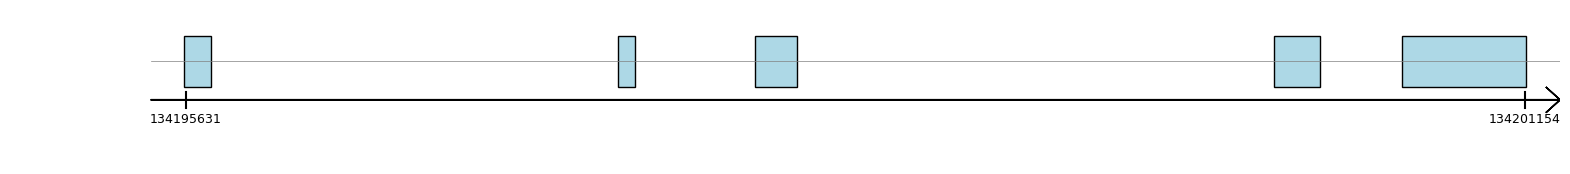

In [19]:
draw_transcript(get_coord_from_tscrpt_id("ENSMUST00000030636"), 1, color="lightblue")

Draw multiple transcripts onto one panel:

In [13]:
#| export
def get_coord_from_tscrpt_id(transcript_id):
    if '.' in transcript_id:
        transcript_id = transcript_id.split('.')[0]
    server = "https://rest.ensembl.org"
    ext = "/lookup/id/" + transcript_id + "?expand=1"

    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})

    if not r.ok:
        r.raise_for_status()
        sys.exit()

    decoded = r.json()
    exon_list = list(decoded['Exon'])
    exon_coord = []
    for i, e in enumerate(exon_list):
        coord = [e.get('end'), e.get('start')]
        exon_coord.append(coord)
    strand = decoded['strand']
    return(exon_coord, strand)


def draw_exons(exons, direction, color, transcript_name, offset=0, start_override=None, end_override=None, no_render=False):
    if not no_render:
        plt.axes()
        plt.xlim((-0.1, 1))
        plt.ylim((-0.3, 0.3))
        plt.margins(0.2)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(20, 2)
    height = 0.2
    plt.plot([offset + 0.1, offset + 0.1], linestyle='solid', linewidth=0.5, c='grey')
    j = 0
    k = 1
    if direction == 1:
        pos_start = exons[0][1]
        pos_end = exons[-1][0]
    else: #direction == -1
        pos_start = exons[-1][1]
        pos_end = exons[0][0]
        j = 1
        k = 0
    real_start = pos_start
    real_end = pos_end
    if start_override is not None and end_override is not None:
        pos_start = start_override
        pos_end = end_override
    total_length = pos_end - pos_start
    total_length_with_margin = 1.05 * total_length
    pos_start_with_margin = pos_start - 0.025*total_length
    for i, exon in enumerate(exons):
        rectangle = plt.Rectangle(((exon[j] - pos_start_with_margin)/total_length_with_margin,offset), (exon[k] - exon[j])/total_length_with_margin, height, fc=color,ec="black")
        plt.gca().add_patch(rectangle)
    if i > 0:
        arrow = None
        if direction < 0:
            arrow = plt.arrow(1, offset - height/4, -1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
        else:
            arrow = plt.arrow(0, offset - height/4, 1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
        plt.gca().add_patch(arrow)
    plt.plot(np.array([0.025 + (real_start - pos_start) / (total_length)/1.05, 0.025 + (real_start - pos_start) / (total_length)/1.05]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
    plt.plot(np.array([1 - 0.025 - (pos_end - real_end) / (total_length)/1.05, 1 - 0.025 - (pos_end - real_end) / (total_length)/1.05]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
    plt.text(0.025 + (real_start - pos_start) / (total_length)/1.05, offset - height/4 - 0.075, real_start, horizontalalignment='center', verticalalignment='center', fontsize=9)
    plt.text(1 - 0.025 - (pos_end - real_end) / (total_length)/1.05, offset - height/4 - 0.075, real_end, horizontalalignment='center', verticalalignment='center', fontsize=9)
    plt.text(1, offset - height, transcript_name, horizontalalignment='right', verticalalignment='top', fontsize=12)
    if not no_render:
        plt.show()


def draw_transcripts_list(transcripts_list, colors=None):
    exons = []
    directions = []
    for tr in transcripts_list:
        t, d = get_coord_from_tscrpt_id(tr)
        exons += [t]
        directions += [d]
    if colors is None:
        colors = []
        for i in range(len(exons)):
            colors.append(['lightblue', 'lightgreen', 'orange', 'yellow', 'brown'][i % 5])
    def get_limits(ex, dir):
        start = sys.maxsize
        end = -sys.maxsize
        for (e, d) in zip(ex, dir):
            if d == 1:
                start = min(start,e[0][1])
                end = max(end, e[-1][0])
            else:
                start = min(start,e[-1][1])
                end = max(end, e[0][0])
        return (start, end)
    plt.axes()
    plt.xlim((-0.1, 1.1))
    plt.ylim((0.1 - 0.5 *  len(exons), 0.3))
    plt.margins(0.2)
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(20, len(exons) * 2)
    i = 0
    (start, end) = get_limits(exons, directions)
    for (ex, di, co, name) in zip(exons, directions, colors, transcripts_list):
        draw_exons(ex, di, co, name, offset= -0.5 * i, start_override=start, end_override=end, no_render=True)
        i+=1
    plt.show()

Test for multiple transcripts:

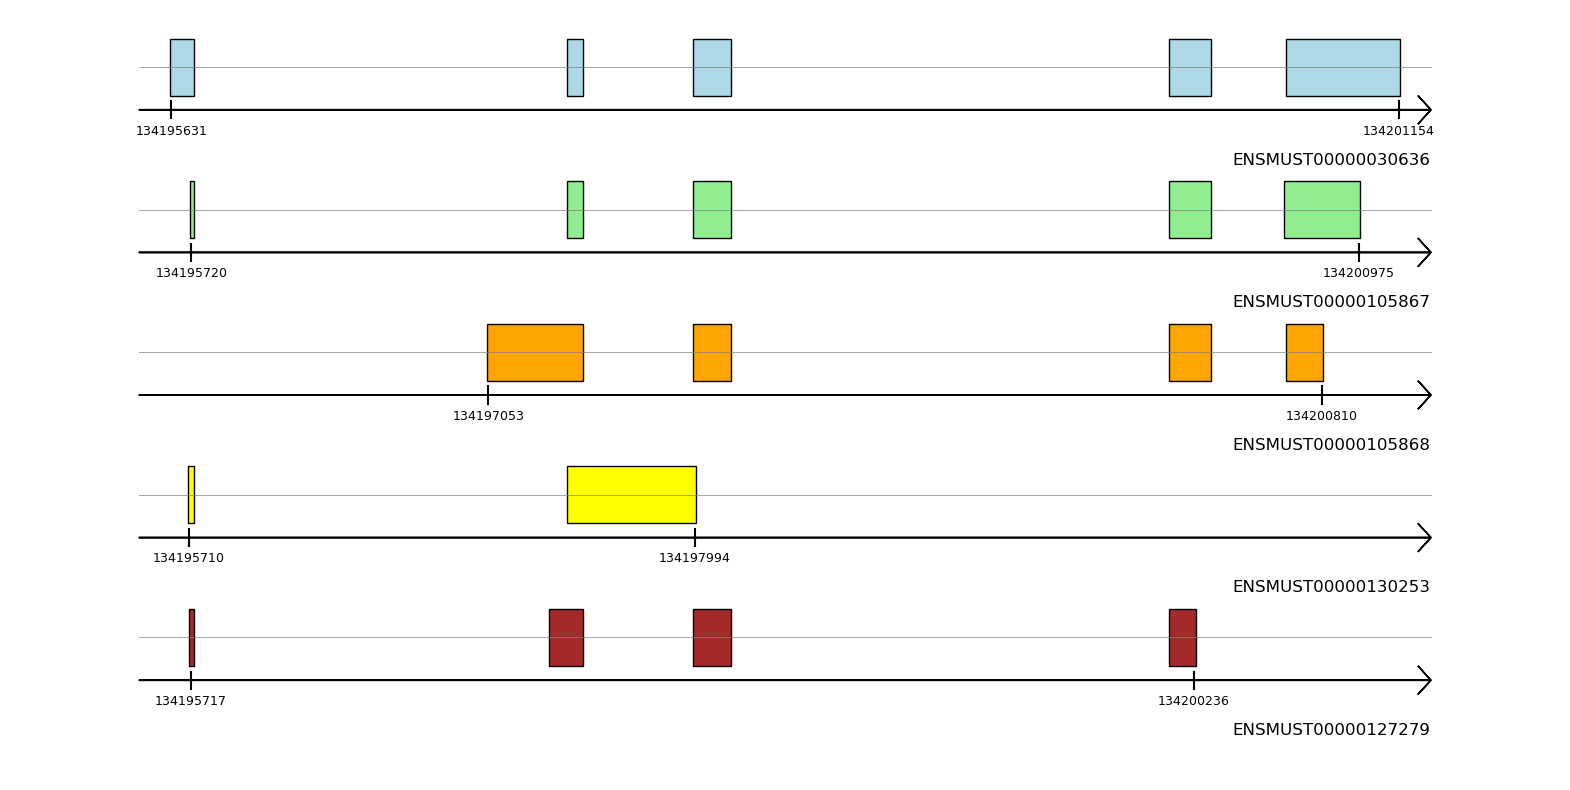

In [14]:
draw_transcripts_list(["ENSMUST00000030636", "ENSMUST00000105867", "ENSMUST00000105868", "ENSMUST00000130253", "ENSMUST00000127279"])

In [ ]:
#| hide 
from nbdev.showdoc import *

In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()